In [1]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
#正态分布的概率密度函数。x（自变量） mu（均值）和 sigma（标准差）
def normfun(x,mu,sigma):
    pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf


标准正态分布图像

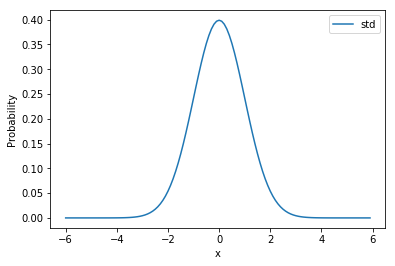

In [3]:
# 设定 x 轴前两个数字是 X 轴的开始和结束，第三个数字表示步长，或者区间的间隔长度
x_range = np.arange(-6,+6,0.1) #画图时只取从-6到+6步长为0.1共120个点来画
y_std = normfun(x_range, 0, 1)
plt.plot(x_range,y_std,label='std')
plt.legend()
plt.xlabel('x')
plt.ylabel('Probability')
#输出
plt.show()

In [4]:
#概率密度混合
def mix(dict_f):
    K=dict_f['K']
    GMM_mixture=np.zeros(120)
    for i in range(K):
        y = normfun(x_range,dict_f['means'][i],dict_f['stds'][i])
        GMM_mixture=GMM_mixture+dict_f['pi'][i]*y
    return GMM_mixture

#采样函数，dict_f为采样参数的字典，N为采样个数
def sample(dict_f,N):
    K=dict_f['K']
    X=np.array([])
    for k in range(K):
        Nk=int(N*dict_f['pi'][k])
        Xk=np.random.randn(Nk)*dict_f['stds'][k]+dict_f['means'][k]
        X=np.append(X,Xk)
    return X

任务：三个一维高斯混合求解：
选定两个高斯，分别为：
y1:mean1=-2 std1=1
y2:mean2=2 std2=2
y3:mean3=0 std2=0.5
混合系数为0.2\0.6\0.2

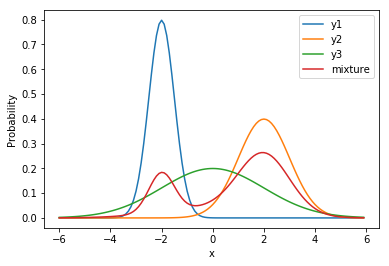

In [5]:
# 设定 x 轴前两个数字是 X 轴的开始和结束，第三个数字表示步长，或者区间的间隔长度

dict_f={'K':3,'pi':[0.2,0.6,0.2],'means':[-2,2,0],'stds':[0.5,1,2]}

x = np.arange(-6,6,0.1) 
y1 = normfun(x,dict_f['means'][0],dict_f['stds'][0])
y2 = normfun(x,dict_f['means'][1],dict_f['stds'][1])
y3 = normfun(x,dict_f['means'][2],dict_f['stds'][2])

mixture = mix(dict_f)

plt.plot(x_range,y1,label='y1')
plt.plot(x_range,y2,label='y2')
plt.plot(x_range,y3,label='y3')
plt.plot(x_range,mixture,label='mixture')

plt.legend()
plt.xlabel('x')
plt.ylabel('Probability')
#输出'
plt.show()

从以上高斯中采样出实际数据点

(100000,)


/home/mis/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


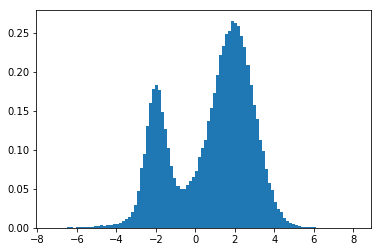

In [6]:
X=sample(dict_f,100000)
print(X.shape)
plt.hist(X,bins=100,normed=True)
#输出'
plt.show()

定义GMM模型，输入为采样数据X，预估高斯个数K，迭代次数，输出为K个高斯分别的系数mean和std，以及它们之间的混合系数pi

In [7]:
def GMM_model(X,K,iternum):
    epsilon=0.00001
    pi=np.random.rand(K)
    pi=pi/np.sum(pi)
    means=np.random.rand(K)
    stds=np.random.rand(K)
    print('随机初始参数：')
    print('pi:',pi)
    print('means:',means)
    print('stds:',stds)
    
    #初始化隐变量r
    N=X.shape[0]  #N为总数据量
    r=np.zeros(shape=(N,K),dtype='float64')
    print(r.shape)
    
    for it in range(iternum):
        #迭代求解
        #求r
        for k in range(0,K):
            r[:,k]=pi[k]*normfun(X,means[k],stds[k])
        rsum=np.sum(r,axis=1,dtype='float64')
        #print(rsum)
        for i in range(N):
            r[i,:]=(r[i,:]+epsilon)/(rsum[i]+epsilon*K)
        #print(r)

        #求Nk
        Nk=np.sum(r,axis=0)
        #print('Nk',Nk)

        #求means
        for k in range(0,K):
            means[k]=(1/Nk[k])*np.sum(r[:,k]*X)
        #print('means',means)

        #求stds
        for k in range(0,K):
            stds[k]=np.sqrt((1/Nk[k])*np.sum(r[:,k]*(X-means[k])**2))
        #print('stds',stds)

        #求pi
        pi=Nk/N
        #print('pi',pi)
        
        if it%100==0:
            print('iter:',it)
            
    return {'K':K,'pi':pi,'means':means,'stds':stds}
    

In [8]:
res=GMM_model(X,3,1000)

随机初始参数：
pi: [ 0.46520904  0.11993955  0.41485141]
means: [ 0.66503384  0.62350616  0.56788061]
stds: [ 0.77334286  0.96011072  0.58202744]
(100000, 3)
iter: 0
iter: 100
iter: 200
iter: 300
iter: 400
iter: 500
iter: 600
iter: 700
iter: 800
iter: 900


In [9]:
print(res)

{'K': 3, 'pi': array([ 0.13273491,  0.22246111,  0.64480397]), 'means': array([-0.15356811, -1.9634527 ,  1.94698729]), 'stds': array([ 2.05260898,  0.57198113,  1.04410979])}


根据算出的高斯重新画图，并与原混合高斯对比

/home/mis/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


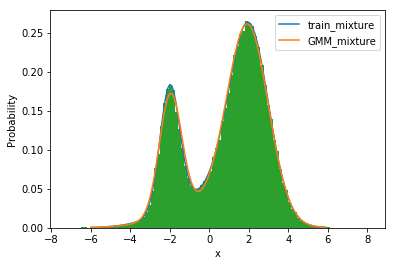

In [10]:
x = np.arange(-6,6,0.1) 

GMM_mixture=mix(res)
plt.plot(x_range,mixture,label='train_mixture')
plt.plot(x_range,GMM_mixture,label='GMM_mixture')
plt.hist(X,bins=100,normed=True)

plt.legend()
plt.xlabel('x')
plt.ylabel('Probability')
#输出'
plt.show()